# Project 3 by Giulio Benedetti

In [3]:
# Import necessary packages
import numpy as np
import pandas as pd
from sklearn import metrics
from collections import Counter
from matplotlib import pyplot as plt
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")

## Task 1: Inferring decoding and encoding

### Section A

**Bonus**: I read the entire paper and discussed some of its other sections in my answers below.

I. _Encoding and decoding definitions and limitations_:

Decoding models learn mapping from neural responses to corresponding stimuli or behavioural outcomes to reveal whether information is contained in the brain. Encoding models learn mapping in the reverse direction to predict how information is represented in the brain.

Decoding models:
- brought about a shift of paradigm from neural activity to information content, which enables researchers to ask more useful questions about whether responses in specific regions encode information.
- leverage the highly multivariate data generated by modern neuroimaging methods, whereas previous approaches had to treat lower-level patterns as noise and smoothen them.
- are trained on one dataset and tested on an independent dataset. Unlike distribution-dependent models, inappropriate assumptions are reflected in low performance, which makes them less prone to incorrect conclusions.

However, they:
- cannot be interpreted as brain-computational models when they reverse the natural direction of information flow and are limited to linear operations.
- feature weights are inter-dependent, thus they do not necessarily translate to significant individual contributions, a problem known as the feature fallacy.
- cannot be used to characterise the representational or computational properties of the brain. They only provide evidence that information can be explained by neural responses.

Encoding models:
- accept more complex sets of descriptive features than traditional linear models, thus regularisation plays a relevant role.
- are compatible with nonlinear components, thus represent more realistic models
- are tested on an independent dataset of experimental conditions, similar to decoding. 
- can be interpreted as brain-computational models when they follow the natural direction of information flow, such as in sensory systems.

However, they:
- predict univariately from different response channels, which ignores correlations between features, increases multiple testing and complicates between-subject comparisons. 
- feature weights cannot be easily interpreted because they depend on the model fit, which is one from an infinite amount. This is related to the problem of feature fallacy.

II. _Challenges in inferring decoding and encoding_:

George E.P. Box’s famous quote goes “All models are wrong, but some are useful”. Such concept holds for decoding and encoding as well, which come with three main caveats. First, the boundary between encoding and decoding is arbitrarily chosen based on the brain region under investigation. In fact, they represent two halves of the same processing path. Second, there might exist other processing paths than the one involving the region under investigation through which the same information flows. Thus, models provide a partial yet useful representation of information content and format. Third, encoders and decoders do not always follow the natural direction of information flow (from stimulus to response and from response to behavioural outcome, respectively), in which case they cannot be used to infer computational mechanisms of the brain.

By default, decoding models only provide evidence of information content for a region of interest rather than an exact representation of its computational mechanisms, both for the caveats explained above as well as the limitations described in question I. However, decoding models can be interpreted as brain-computational models when they satisfy a few conditions. First, they should be biologically plausible. Linear models reduce complexity and simplify interpretation, but they do not represent a realistic view of computational mechanisms. Second, they should follow the natural direction of information flow, from neural responses to behavioural outcomes. Even when these assumptions are satisfied, computational theories should not be assessed on the basis of a single model, which might lead to the single-model significance fallacy. Instead, several models should be considered and compared against one another.

III. _How to decode_:

Three popular decoding approaches entail linear models, stimulus reconstruction and behavioural prediction. Linear models are well established and suitable for response categories that are at least in part linearly separable. The level of explainable complexity is limited to linear and simple nonlinear relations, and thus linear models might fit well single-neuron operations which process so-called explicit information. Stimulus reconstruction aims to re-code the stimulus from the produced response. Although it provides much richer and more ambitious information than linear models, its interpretation is not as straightforward, especially because relatively complex priors might be set to simplify the output space. Decoders for behavioural prediction, where behaviour may consist of reaction time or response category, follow the natural direction of information flow, thus they can be interpreted as brain-computational models. They are still subject to the tradeoff between complexity and explainability.

Generalisation of decoders is statistically advantageous to test information content because they are inherently multivariate, thus they exploit noise correlations between features to fit the model. Additionally, the model is trained on one dataset and evaluated on independent data to avoid overfitting.

The need of generalisation is particularly stringent for stimulus reconstruction, where the stimulus space is so diverse that is hard to learn exhaustively, especially given the limited size of the train set. Therefore, the train conditions have to be sampled from the stimulus space smartly, well exemplified by Pereira et al., 2018, in the context of semantic representation of words. To improve the quality of reconstruction, priors can be imposed to limit the output space to realistic stimuli. However, this makes performance depend not only on information content but also the complexity of the output space, which must be considered when interpreting results. In machine learning jargon, these two parameters are not othogonalised, since they affect the same outcome.

### Section B

The encoder below generates a population vector for an input angle from a set of n neurons, which show preference for angles that are equally distant within a circle. The input angle is then predicted from the population vector and returned as output along with the firing rates of the set of neurons.

In [2]:
# Define function that computes population vector and predicted direction
def encoder(angle, n, r0=55, noise=False):

    circle = 2 * np.pi
    step = circle / n
    
    alpha = np.linspace(0, circle - step, n)
    r = np.maximum(0, r0 * np.cos(angle - alpha) + int(noise) * np.random.normal(0, 4, n))

    pop = (r - r0) / np.max(r)
    x = np.sum(pop * np.cos(alpha))
    y = np.sum(pop * np.sin(alpha))

    pred = np.arctan(y / x)

    if x > 0 and y < 0:
        pred += 2 * np.pi
    elif x < 0:
        pred += np.pi

    return r, pred

### Section C

The function below samples angles from a circular space at a distance of 1 degree from each other. Then, it performs encoding and predicts the input angle.

In [3]:
# Perform encoding and decoding for a set of directions
def encode_circle(angles, n, noise=False):

    r_list = []
    pred_list = []

    for angle in angles:
    
        r, pred = encoder(angle, n, noise=noise)
    
        r_list.append(r)
        pred_list.append(pred)

    r = np.array(r_list)
    pred = np.array(pred_list)

    return r, pred

A set of 4 neurons are used to represent the angles from the circular space.

In [4]:
# Define circular space
angles = np.linspace(0, 2 * np.pi, 360)
ticks_range = np.linspace(0, 2 * np.pi, 5)

# Encode circular space with 4 neurons
r4, pred4 = encode_circle(angles, 4)

To interpret the results, the tuning curves of the four neurons and the predicted angles are visualised as a function of the actual angles.

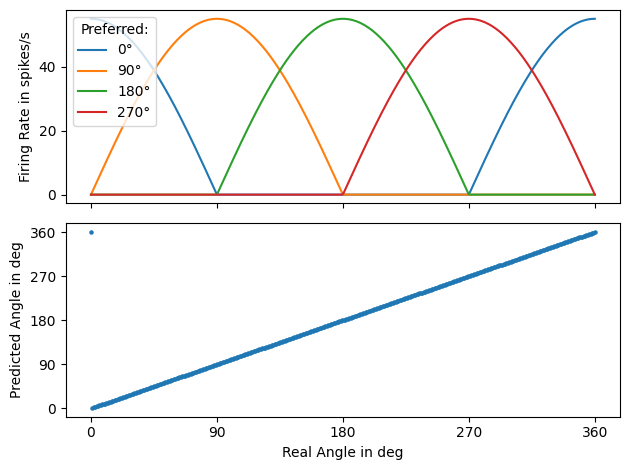

In [5]:
# Visualise encoding and decoding performance
fig, axes = plt.subplots(2, sharex=True)

axes[0].plot(angles, r4)

axes[0].set_xticks(ticks_range, np.rad2deg(ticks_range).astype(int))

axes[0].set_ylabel("Firing Rate in spikes/s")
axes[0].legend(["0°", "90°", "180°", "270°"], title="Preferred:", loc = "upper left")

axes[1].scatter(angles, pred4, s=5)

axes[1].set_xticks(ticks_range, np.rad2deg(ticks_range).astype(int))
axes[1].set_yticks(ticks_range, np.rad2deg(ticks_range).astype(int))

axes[1].set_xlabel("Real Angle in deg")
axes[1].set_ylabel("Predicted Angle in deg")

plt.tight_layout()

The tuning curves of the four neurons suggest that neurons respond to wind directions in a range of 180° around their preferred direction, which corresponds to a peak firing rate of 55 spikes/s. Additionally, the tuning curves behave as the positive portion of a cosine function and are uniformly distributed over the circular space.

Overall, predictions seem very accurate across the entire circular space. However, angles are sometimes assigned to the incorrect direction (upwards or downwards) along the horizontal axis for small (~ 0°) and large angles (~ 360°). Comprehensively, four neurons seem sufficient to represent wind directions in a flat two-dimensional space, whereas three or fewer neurons fail (it can be tested by setting the function parameter n to 3 or less). Similarly, four neurons might not be enough to represent a 3-dimensional space, which is a question for a different project.

### Section D

The same function can be used for a set of eight neurons positioned at equal distances in terms of preferred wind direction by setting the argument n to eight.

In [6]:
# Encode circular space with 8 neurons
r8, pred8 = encode_circle(angles, 8)

# Encode circular space with an odd number of neurons
r5, pred5 = encode_circle(angles, 5)
r7, pred7 = encode_circle(angles, 7)

The predictive performance for four, five, seven and eight neurons is visualised in terms of predicted angles as a function of real angles.

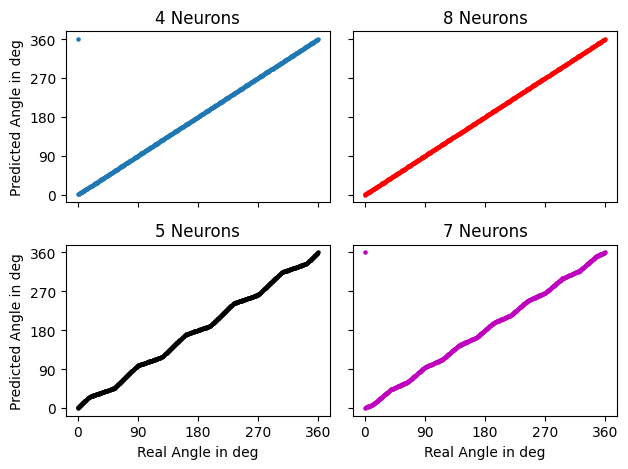

In [7]:
# Compare predictive performance
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)

axes[0, 0].scatter(angles, pred4, s=5)

axes[0, 0].set_xticks(ticks_range, np.rad2deg(ticks_range).astype(int))
axes[0, 0].set_yticks(ticks_range, np.rad2deg(ticks_range).astype(int))

axes[0, 0].set_ylabel("Predicted Angle in deg")
axes[0, 0].set_title("4 Neurons")

axes[0, 1].scatter(angles, pred8, c="r", s=5)

axes[0, 1].set_xticks(ticks_range, np.rad2deg(ticks_range).astype(int))
axes[0, 1].set_title("8 Neurons")

axes[1, 0].scatter(angles, pred5, c="k", s=5)

axes[1, 0].set_xticks(ticks_range, np.rad2deg(ticks_range).astype(int))
axes[1, 0].set_yticks(ticks_range, np.rad2deg(ticks_range).astype(int))

axes[1, 0].set_xlabel("Real Angle in deg")
axes[1, 0].set_ylabel("Predicted Angle in deg")
axes[1, 0].set_title("5 Neurons")

axes[1, 1].scatter(angles, pred7, c="m", s=5)

axes[1, 1].set_xticks(ticks_range, np.rad2deg(ticks_range).astype(int))
axes[1, 1].set_xlabel("Real Angle in deg")
axes[1, 1].set_title("7 Neurons")

plt.tight_layout()

In the absence of noise, the four and eight-neuron models perform comparatively well. In either model, there does not seem to be a region in particular where prediction consistently fails. This is expected, since the preferred wind directions of the neurons are uniformly distributed over the circular space, and therefore every region is equally covered.

Interestingly, an odd number of neurons, such as five or seven, overestimates and underestimates angles in an alternated way, because neurons lack a complementary neuron in the oppositve side of the circle, and thus give an unbalanced contribution to the population vector. The results for five and seven neurons are visualised above for reference.

### Section E

`sim` Multiple simulations of a system with n neurons with or without noise can be performed with the function below. General means, standard deviations and Root Mean Squared Errors (RMSEs) are then computed from the `sim` predictions for every angle in the circular space.

In [8]:
# Define function that measures performance from muliple simulations
def simulate_encoding(angles, n, sim=100, noise=False):

    pred_list = []
    
    for i in range(sim):
        _, pred = encode_circle(angles, n, noise=noise)
        pred_list.append(pred)
    
    pred_arr = np.array(pred_list)
    
    avg = np.mean(pred_arr, axis=0)
    stdev = np.std(pred_arr, axis=0)
    rmse = np.mean(np.sqrt((angles - pred_arr)**2), axis=0)

    return avg, stdev, rmse

100 simulations are run with Gaussian noise $N(0, 4)$ for the four and eight-neuron models. Standard errors are computed from the standard deviations. However, uncertainty is represented in the figures below in terms of standard deviation to improve visibility.

In [9]:
# Set number of simulations
sim = 100

# Find mean, sd and rmse for 4 and 8 neurons
avg4, stdev4, rmse4 = simulate_encoding(angles, 4, noise=True)
avg8, stdev8, rmse8 = simulate_encoding(angles, 8, noise=True)
avg100, stdev100, rmse100 = simulate_encoding(angles, 100, noise=True)

# Compure standard error
sem4 = stdev4 / np.sqrt(sim - 1)
sem8 = stdev8 / np.sqrt(sim - 1)

Means and standard deviations of predictions as a function of real angles are visualised below for the two models.

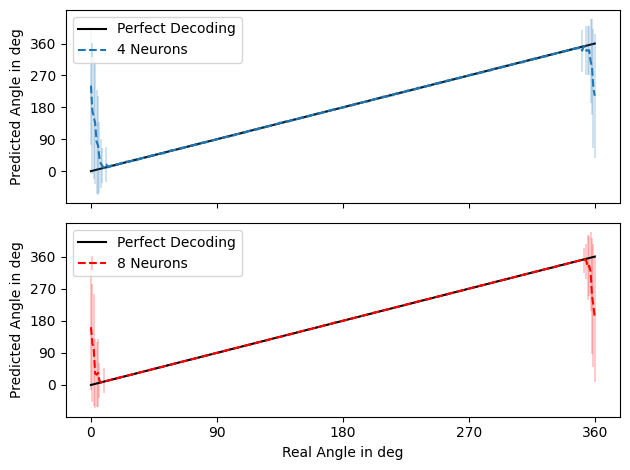

In [10]:
# Visually compare predictive performance
fig, axes = plt.subplots(2, sharex=True)

axes[0].plot(angles, angles, label="Perfect Decoding", c="k")
axes[0].errorbar(angles, avg4, yerr=stdev4, elinewidth=0.3, label="4 Neurons", linestyle="--")

axes[0].set_ylabel("Predicted Angle in deg")
axes[0].legend(loc="upper left")

axes[0].set_xticks(ticks_range, np.rad2deg(ticks_range).astype(int))
axes[0].set_yticks(ticks_range, np.rad2deg(ticks_range).astype(int))

axes[1].errorbar(angles, avg8, yerr=stdev8, elinewidth=0.3, label="8 Neurons", c="r", linestyle="--")
axes[1].plot(angles, angles, label="Perfect Decoding", c="k")

axes[1].set_xlabel("Real Angle in deg")
axes[1].set_ylabel("Predicted Angle in deg")

axes[1].set_yticks(ticks_range, np.rad2deg(ticks_range).astype(int))
axes[1].legend(loc="upper left")

plt.tight_layout()

Both models perform close to perfect decoding (black line) for angles between 20° and 340°, whereas prediction seems to fail for angles in a 20°-range around 0°. This is likely not only due to the formal distance but practical equality of 0° and 360°, because predictions gradually worsen as they approach 0° instead of shifting drammatically from angles close to 0° to ones close to 360°.

Compared to the four-neuron model, the eight-neuron model seems to maintain good predictive performance in a region slightly closer to small and null angles. The following figure of the RMSE as a function of real angles illustrates such divergence in a rather clear manner.

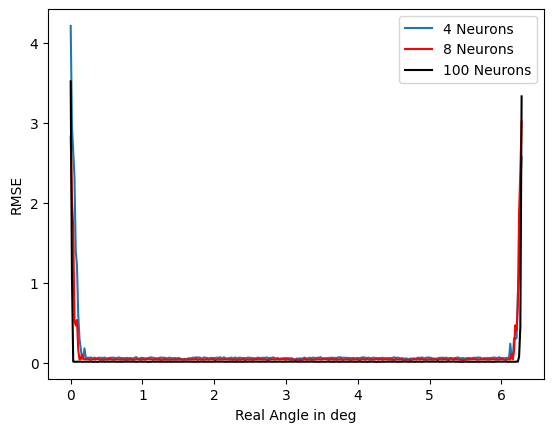

In [11]:
# Visually compare RMSE by direction
plt.plot(angles, rmse4, label="4 Neurons")
plt.plot(angles, rmse8, c="r", label="8 Neurons")
plt.plot(angles, rmse100, c="k", label="100 Neurons")

plt.xlabel("Real Angle in deg")
plt.ylabel("RMSE")
plt.legend()

As mentioned above, the eight-neuron model (red line) shows marginally better performance than the four-neuron model (blue line) over the entire circular space, and especially at angles close to 0°. The slighly better performance of the former model reflects the improved signal-to-noise ratio which results from a population vector obtained from a larger set of neurons (eight vs four). Similarly to ensemble learning, a global decision among multiple predictors provides better accuracy and less uncertainty than every individual predictor. Therefore, a model with a relatively large number of predictors, such as 100 neurons (black line), exhibits virtually perfect accuracy and no noise.

In [12]:
# Compare total RMSE
print(f"Total RMSE for 4 neurons: {rmse4.sum():.5g}")
print(f"Total RMSE for 8 neurons: {rmse8.sum():.5g}")
print(f"Total RMSE for 100 neurons: {rmse100.sum():.5g}")

Total RMSE for 4 neurons: 43.466
Total RMSE for 8 neurons: 31.342
Total RMSE for 100 neurons: 12.511


The performances of the models can be quantified as the sum of the RMSEs for all angles. It can be observed that performance does not improve linearly with the number of neurons. In fact, improvement increases more slowly as the number of neurons rises.

### Section F

In line with the current findings, it might prove interesting to explore the following questions:

1. _Model predictive performance with respect to the number of neurons_. This research direction would help reveal how many neurons should be considered minimal in order to obtain a sufficiently accurate prediction, and generate a-priori estimates on the number of neurons necessary to achieve the desired performance.
2. _Study encoding and decoding in a 3-dimensional space_. This research direction would enrich our knowledge of how dimensional complexity affects predictive performance and how its relationship with the number of neurons may behave differently compared to a 2-dimensional space.
3. _Extend analyses in the temporal domain with trains of stimuli_. This research direction would provide the tools to analyse reaction times to changes in input angles, and model how accuracy of predictions may vary with respect to the speed of change in the input angles.

In general, it is recommended to proceed from easier to more complex experiments (from 1 to 3). After completing the experiments separately, it is also possible to combine them into a comprehensive analysis to observe if interesting interactions emerge.

## Task 2: Estimators MAP and MLE

### Section A

The data on actual and perceived sound upon hearing \bi\ is imported below.

In [13]:
# Import dataset
df = pd.read_csv("perceived_b.csv")
df.columns = ["actual_sound", "perceived_sound"]

The conditional probability of hearing \bi\ given a sound X is computed as the ratio of sessions where X led to the perception of \bi\\.

In [14]:
# Count occurrences of every sound
library = Counter(df["actual_sound"])
prob_df = pd.DataFrame(index=library.keys())

# Find frequency of every sound
prob_df["library"] = library.values()
prob_df["likelihood"] = prob_df["library"] / prob_df["library"].sum()

The conditional probability of perceiving \bi\ is then visualised with a bar plot.

Text(0, 0.5, 'Conditional Probability of \\bi\\')

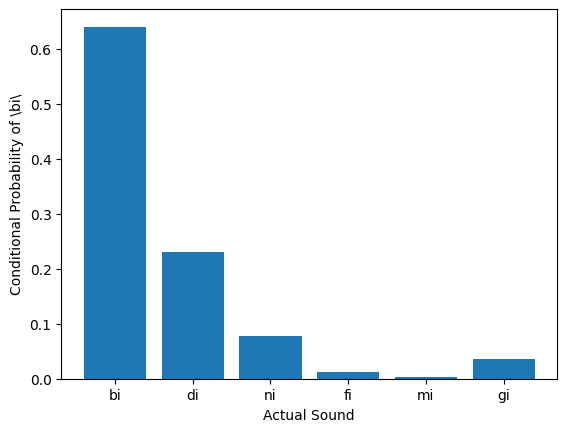

In [15]:
# Visualise conditional probability of perceived sound \bi\
plt.bar(prob_df.index, prob_df["likelihood"])
plt.xlabel("Actual Sound")
plt.ylabel("Conditional Probability of \\bi\\")

### Section B & C

The Maximum Likelihood Estimator (MLE) and the Maximum A-Priori (MAP) represent two types of estimators to predict the optimal parameter or condition that led to a given outcome. Given the conditional probability $P(x\lvert \Theta)$ of the outcome $x$ and the prior distribution $P(\Theta)$ of the condition $\Theta$, the MLE and the MAP can be mathematically formulated as:

$$
MLE:\quad \hat{\Theta} = arg\, max\, P(x\lvert \Theta)
$$

$$
MAP:\quad \hat{\Theta} = arg\, max\, P(x\lvert \Theta)\cdot P(\Theta)
$$

In the current experiment, the MLE can be derived from the conditional probability obtained in the previous section, and the MAP from the conditional probability multiplied by the prior distribution of actual sounds.

In [16]:
# Set prior
prob_df["prior"] = [1.1, 0.2, 33.7, 0.01, 2.5, 15.3]

# Find MAP
prob_df["MLE"] = prob_df["likelihood"]
prob_df["MAP"] = prob_df["prior"] * prob_df["likelihood"]

print(tabulate(prob_df, headers="keys"))

      library    likelihood    prior         MLE          MAP
--  ---------  ------------  -------  ----------  -----------
bi        164    0.640625       1.1   0.640625    0.704688
di         59    0.230469       0.2   0.230469    0.0460938
ni         20    0.078125      33.7   0.078125    2.63281
fi          3    0.0117188      0.01  0.0117188   0.000117187
mi          1    0.00390625     2.5   0.00390625  0.00976562
gi          9    0.0351562     15.3   0.0351562   0.537891


The table illustrates the likelihoods (MLE) and posteriors (MAP) of every sound being perceived. The MLE and MAP can be determined by indexing the argmax of each array.

In [17]:
# Predict perceived sound from MLE
mle_est = prob_df["MLE"].idxmax()
# Predict perceived sound from MLE
map_est = prob_df["MAP"].idxmax()

print(f"MLE estimator: {mle_est}")
print(f"MAP estimator: {map_est}")

MLE estimator: bi
MAP estimator: ni


As a result, MLE and MAP predict \bi\ and \ni\ as the perceived sound, respectively. This divergence in prediction is caused by the different definitions of MLE and MAP. While the former only considers the relative likelihoods of an event given a condition and assumes equal priors for every condition, the latter weights the relative likelihoods with priors obtained from previous knowledge. Therefore, even though the perceived sound \bi\ is expected from the MLE because it is the most likely from the given dataset, MAP predicts \ni\ because of the relative frequencies of different sounds in a given language.

### Section D

In a different country where prior probabilities of hearing a sound differ, the MLE will remain unchanged, but the MAP will be affected by the new prior probabilities. Therefore, if \bi\ and not \ni\ is now one of the more frequent sounds in that language, the prediction might go in the favour of \bi\ bein perceived. Such scenario is exemplified below with made-up statistics of the sounds in the new country.

In [18]:
# Set new prior
prob_df["prior2"] = [30, 9, 2, 15, 7, 22]
# Find new MAP
prob_df["MAP2"] = prob_df["prior2"] * prob_df["likelihood"]

# Predict perceived sound from new MAP
map_est = prob_df["MAP2"].idxmax()

print(f"MLE estimator: {mle_est}")
print(f"MAP estimator: {map_est}")

MLE estimator: bi
MAP estimator: bi


It is possible to observe that the largest relative frequency of 30 is attributed to \bi\, and therefore the MAP predicts \bi\ as the perceived sound.

## Task 3: Information theory

### Section A

The entropy of an H neuron that responds to smell of either lemon or cinnamon can be computed with the following function.

In [4]:
# Define function to compute entropy
def find_entropy(freq, prob, show=True):

    entropy = -np.sum(freq * prob * np.log2(prob) + freq * (1 - prob) * np.log2(1 - prob))

    if show:
        print(f"Exposures: {freq}")
        print(f"Probabilities: {prob}")
        print(f"Entropy: {entropy:.2f}")
    
    return entropy

If the exposures to lemon and cinnamon are equal, the entropy of the H neuron equals 0.68 bits.

In [5]:
# Set first exposure and probability
exposure1 = np.array([0.5, 0.5])
prob = np.array([0.75, 0.125])

# Compute entropy for equal exposure
entropy1 = find_entropy(exposure1, prob)

Exposures: [0.5 0.5]
Probabilities: [0.75  0.125]
Entropy: 0.68


If the exposures to lemon and cinnamon are 1% and 0.99%, respectively, the entropy of the H neuron equals 0.55 bits.

In [6]:
# Set second exposure
exposure2 = np.array([0.01, 0.99])

# Compute entropy for unequal exposure
entropy2 = find_entropy(exposure2, prob)

Exposures: [0.01 0.99]
Probabilities: [0.75  0.125]
Entropy: 0.55


As expected, a situation where probabilities are unequal is characterised by a smaller entropy than one where probabilities are equal.

### Section B

The conditional entropy $H(H\lvert S)$ can be obtained from the relationship $I(H, S) = H(H) - H(H\lvert S)$. First, the total entropy and the mutual information must be found.

In [7]:
# Define function to compute mutual information
def find_information(freq, prob, show=True):

    prior = np.sum(freq * prob)
    information = np.sum(freq * prob * np.log2(prob / prior) + freq * (1 - prob) * np.log2((1 - prob) / (1 - prior)))

    if show:
        print(f"Prior: {prior:.2f}")
        print(f"Information gain: {information:.3g}")
    
    return information

The total entropy can be computed with the function defined in the previous section.

In [8]:
# Set exposure
exposure = np.array([0.4, 0.6])

# Compute entropy
entropy = find_entropy(exposure, prob)

Exposures: [0.4 0.6]
Probabilities: [0.75  0.125]
Entropy: 0.65


The mutual information can be found with the function defined at the beginning of the current sections.

In [9]:
# Compute mutual information
information = find_information(exposure, prob)

Prior: 0.38
Information gain: 0.304


Finally, the total entropy and the mutual information are plugged in the formula, which returns a conditional entropy of 0.347 bits.

In [10]:
# Calculate conditional entropy
conditional_entropy = entropy - information
print(f"Conditional Entropy: {conditional_entropy:.3g}")

Conditional Entropy: 0.347


The result seems reasonable, as it lies between 0 and the total entropy. The mutual information about the neuron gained by knowledge of the smell represents about 47% of the original entropy, which correctly reflects the different probabilities of response for the two smells.

### Section C

Marcel's neurons show ideal positive correlation (r = 1), whereas Leonie's neurons exhibit null correlation and thus complete linear independence (r = 0). This leads to different joint entropies between the two sets of neurons.

In [11]:
# Visualise cross-correlation matrices for Marcel and Leonie
marcel = np.ones((2, 2))
leonie = np.array([1, 0, 0, 1]).reshape(2, 2)

print("Marcel:")
print(marcel)
print("Leonie:")
print(leonie)

Marcel:
[[1. 1.]
 [1. 1.]]
Leonie:
[[1 0]
 [0 1]]


In [12]:
# Define function to compute joint entropy (check if it's correct)
def find_joint_entropy(freq, prob, entropy, show=True):
    
    conditional_entropy = find_entropy(freq, prob, show=False)
    joint_entropy = entropy + conditional_entropy

    if show:
        print(f"Conditional Entropy: {conditional_entropy:.3g}")
        print(f"Joint Entropy: {joint_entropy:.3g}")

    return joint_entropy

Marcel's neurons show perfect correlation and therefore their firing is co-occurring. In this case, their conditional entropy is null and their joint entropy is equivalent to that of a single neuron.

In [13]:
# Store joint probabilities of firing
joint_freq1 = np.array([0.625, 0.375])
joint_prob1 = np.array([1e-10, 1 - 1e-10])

# Compute second joint entropy
joint_entropy1 = find_joint_entropy(joint_freq1, joint_prob1, entropy)

Conditional Entropy: 3.47e-09
Joint Entropy: 0.651


Leonie's neurons do not show correlation and therefore cannot depend on one another. In this case, their conditional entropy corresponds to the total entropy and their joint entropy is equivalent to the sum of their individual entropies.

In [14]:
# Store joint probabilities of firing
joint_freq2 = np.array([0.625, 0.375])
joint_prob2 = np.array([0.375, 0.375])

# Compute second joint entropy
# joint_entropy2 = find_joint_entropy(joint_freq2, joint_prob2, entropy)
joint_entropy2 = 2 * entropy

print(f"Conditional Entropy: {entropy:.3g}")
print(f"Joint Entropy: {joint_entropy2:.3g}")

Conditional Entropy: 0.651
Joint Entropy: 1.3


### Section D

Because Marcel's neurons are perfectly correlated, this reduces to a binary problem: either the neurons fire together, or they do not fire together. Therefore, the K neuron is able to fully represent such binary space by either firing or not firing. In the case of Leonie, the 2 neurons are not correlated and thus might respond together and separately alike, which constitutes a problem with four options. Therefore, the K neuron is not able to fully represent the initial space, that is, it cannot track which of the two H neurons fired.

### Section E

In [19]:
# Set table headers
headers = ["Event", "P(H1, H2)", "P(H1, H2|L)", "P(H1, H2|C)"]

Marcel's neurons exhibit only two types of events: either they both respond, or neither of them responds. The table below presents the prior $P(H_1, H_2)$ and the conditional probabilities given each smell $P(H_1, H_2\lvert L)$ and $P(H_1, H_2\lvert C)$ for Marcel's neurons.

In [20]:
# Set Marcel's prior
prior1 = np.array([0.375, 0.625]).reshape(2, 1)

# Set Marcel's conditional probabilities
conditional_prob1 = np.array([[0.75, 0.125],
                              [0.25, 0.875]])

prob_tab1 = pd.DataFrame(conditional_prob1, index=["++", "--"])
prob_tab1["prior"] = prior1

print(tabulate(prob_tab1, headers=headers))  

Event      P(H1, H2)    P(H1, H2|L)    P(H1, H2|C)
-------  -----------  -------------  -------------
++              0.75          0.125          0.375
--              0.25          0.875          0.625


Leonie's neurons show independent behaviour from one another, and thus their probabilities of firing must be multiplied. The table below presents the prior $P(H_1, H_2)$ and the conditional probabilities given each smell $P(H_1, H_2\lvert L)$ and $P(H_1, H_2\lvert C)$ for Leonie's neurons.

In [32]:
# Set Leonie's prior
prior2 = np.array([0.375**2, 0.375 * 0.625, 0.625 * 0.375, 0.625**2]).reshape(4, 1)

# Set Leonie's conditional probabilities
conditional_prob2 = np.array([[0.75**2, 0.125**2],
                              [0.75 * 0.25, 0.125 * 0.875],
                              [0.25 * 0.75, 0.875 * 0.125],
                              [0.25**2, 0.875**2]])

prob_tab2 = pd.DataFrame(conditional_prob2, index=["++", "+-", "-+", "--"])
prob_tab2["prior"] = prior2

print(tabulate(prob_tab2, headers=headers))           

Event      P(H1, H2)    P(H1, H2|L)    P(H1, H2|C)
-------  -----------  -------------  -------------
++            0.5625       0.015625       0.140625
+-            0.1875       0.109375       0.234375
-+            0.1875       0.109375       0.234375
--            0.0625       0.765625       0.390625


The function below is used to compute the mutual information $I(H_1, H_2; S)$ for each couple of neurons.

In [33]:
# Define function to compute joint information (check if it's correct)
def find_joint_information(prob, freq, prior):
    
    information = np.sum(freq * prob * np.log2(prob / prior))

    return information

In [34]:
# Compute joint mutual information for Marcel and Leonie
joint_information1 = find_joint_information(conditional_prob1, exposure, prior1)
joint_information2 = find_joint_information(conditional_prob2, exposure, prior2)

tab = {"Subject": ["Marcel", "Leonie"], "I(H1, H2; S)": [joint_information1, joint_information2]}

print(tabulate(tab, headers="keys"))

Subject      I(H1, H2; S)
---------  --------------
Marcel           0.303784
Leonie           0.607568


As expected, the mutual information for Leonie's neurons is twice as large as Marcel's. This is because in Marcel's case, the two neurons are perfectly correlated and their joint entropy equals the entropy of a single neuron (0.65 bits). Therefore, knowledge about the smell generates the same shared information between the two neurons (0.3 bits). In Leonie's case, the two neurons are uncorrelated and their joint entropy equals that of two individual neurons (1.3 bits). Therefore, knowledge about the smell generates separate information for the two neurons, which adds up to twice that of one neuron (0.61 bits).

## References

1. Kriegeskorte, Nikolaus, and Pamela K. Douglas. "Interpreting encoding and decoding models." Current opinion in neurobiology 55 (2019): 167-179.
2. Pereira, Francisco, et al. "Toward a universal decoder of linguistic meaning from brain activation." Nature communications 9.1 (2018): 963.